In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 4)
np.random.seed(seed = 23)

In [2]:
data = pd.read_csv('Data/train.csv')
data = data.drop(columns=['id'])
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tweet'])

In [4]:
data['tokenized'] = tokenizer.texts_to_sequences(data['tweet'])
data.head()

,label,tweet,tokenized
0,0,@user when a father is dysfunctional and is s...,"[1, 34, 4, 252, 11, 16533, 7, 11, 20, 2753, 97..."
1,0,@user @user thanks for #lyft credit i can't us...,"[1, 1, 170, 9, 5701, 2600, 5, 68, 452, 680, 69..."
2,0,bihday your majesty,"[62, 26, 3422]"
3,0,#model i love u take with u all the time in ...,"[140, 5, 13, 37, 76, 16, 37, 21, 2, 39, 8, 162..."
4,0,factsguide: society now #motivation,"[2946, 1621, 49, 299]"


In [5]:
vocab_size = len(tokenizer.word_index) + 1
length_size = 15
embedding_dim = 300

In [6]:
X = pad_sequences(sequences = data['tokenized'],
                  maxlen = length_size,
                  padding = 'post')

y = data['label']

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X,
                                                                y, 
                                                                test_size = 0.1,
                                                                random_state = 23)

## Model

In [8]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dim,
                    input_length = length_size))
model.add(Conv1D(filters = 32,
                 kernel_size = 3,
                 padding = 'same',
                 activation = 'relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters = 64,
                 kernel_size = 5,
                 padding = 'same',
                 activation = 'relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1,
                activation = 'sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 300)           13767000  
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 32)            28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dropout (Dropout)            (None, 192)               0

In [10]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [11]:
%%time

history = model.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_validation, y_validation),
                    batch_size = 32,
                    epochs = 20,
                    callbacks = [es])

Epoch 1/20
899/899 [==============================] - 231s 243ms/step - loss: 0.2220 - accuracy: 0.9308 - val_loss: 0.1106 - val_accuracy: 0.9603
Epoch 2/20
899/899 [==============================] - 221s 246ms/step - loss: 0.0528 - accuracy: 0.9817 - val_loss: 0.1207 - val_accuracy: 0.9625
Epoch 3/20
899/899 [==============================] - 221s 246ms/step - loss: 0.0105 - accuracy: 0.9964 - val_loss: 0.1464 - val_accuracy: 0.9593
Epoch 4/20
899/899 [==============================] - 217s 241ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.2340 - val_accuracy: 0.9640
Epoch 5/20
899/899 [==============================] - 215s 239ms/step - loss: 6.7225e-04 - accuracy: 0.9999 - val_loss: 0.2138 - val_accuracy: 0.9606
CPU times: user 35min 53s, sys: 17min 5s, total: 52min 59s
Wall time: 18min 24s


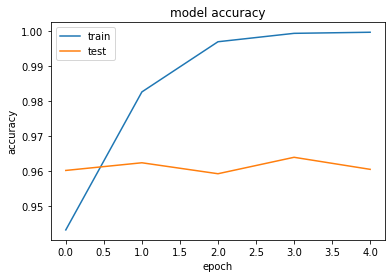

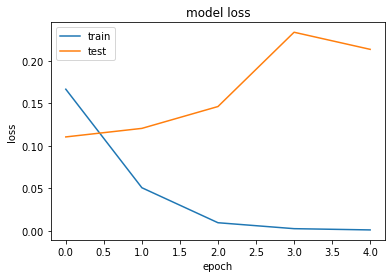

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
loss, accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(loss, accuracy))

Loss: 0.2138, Accuracy: 0.9606


In [14]:
test = pd.read_csv('Data/test.csv')
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [15]:
test['tokenized'] = tokenizer.texts_to_sequences(test['tweet'])
test.head()

,id,tweet,tokenized
0,31963,#studiolife #aislife #requires #passion #dedic...,"[14173, 9102, 1540, 7666, 3, 176]"
1,31964,@user #white #supremacists want everyone to s...,"[1, 238, 40583, 74, 198, 3, 66, 2, 50, 14958, ..."
2,31965,safe ways to heal your #acne!! #altwaystohe...,"[651, 960, 3, 833, 26, 2484, 182, 80, 261]"
3,31966,is the hp and the cursed child book up for res...,"[11, 2, 7, 2, 28167, 588, 366, 46, 9, 412, 72,..."
4,31967,"3rd #bihday to my amazing, hilarious #nephew...","[1671, 62, 3, 12, 161, 2963, 2595, 7553, 3875,..."


In [16]:
X_test = pad_sequences(sequences = test['tokenized'],
                       maxlen = length_size,
                       padding = 'post')

In [17]:
predicted = (model.predict(X_test) > 0.5).astype("int32")
predicted

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [18]:
prediction = pd.DataFrame()
prediction['id'] = test['id']
prediction['label'] = predicted

prediction.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [19]:
prediction.to_csv('teste2.csv', index=False)